<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/examples/multi_modal/gpt4v_multi_modal_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Multi-Modal Retrieval using GPT4V and Multi-Modal Index/Retriever

In this notebook, we show how to build a Multi-Modal retrieval system using LlamaIndex with GPT4-V and CLIP.

LlamaIndex Multi-Modal Retrieval

- Text embedding index: Generate GPT text embeddings
- Images embedding index: [CLIP](https://github.com/openai/CLIP) embeddings from OpenAI for images


Encoding queries:
* Encode query text for text index using ada
* Encode query text for image index using CLIP

Framework: [LlamaIndex](https://github.com/run-llama/llama_index)

Steps:
1. Using Multi-Modal LLM GPT4V class to undertand multiple images
2. Download texts, images, pdf raw files from related Wikipedia articles and SEC 10K report
2. Build Multi-Modal index and vetor store for both texts and images
4. Retrieve relevant text and image simultaneously using Multi-Modal Retriver according to the image reasoning from Step 1

In [ ]:
%pip install git+https://github.com/run-llama/llama_index.git
%pip install ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client

  Cloning https://github.com/run-llama/llama_index.git to /tmp/pip-req-build-uoejmrp5
  Running command git clone --filter=blob:none --quiet https://github.com/run-llama/llama_index.git /tmp/pip-req-build-uoejmrp5
  Resolved https://github.com/run-llama/llama_index.git to commit 83fdd4563587003b04a308520d84211f2473e144
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.4/221.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.9 MB/s eta 0:00:00


In [ ]:
import os

OPENAI_API_TOKEN = "sk-..."
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN

## Download our set of images of cars

In [ ]:
!rm -rf ./cars
!rm -rf ./__MACOSX
!wget "https://www.dropbox.com/scl/fi/48f5vfp86ak56tv6647ru/cars.zip?rlkey=8vre28paljf4ovf5269a1w0as&dl=0" -O cars.zip -q
!unzip cars.zip -d .

Archive:  cars.zip
   creating: ./cars/
  inflating: ./__MACOSX/._cars       
  inflating: ./cars/t1.jpg           
  inflating: ./__MACOSX/cars/._t1.jpg  
  inflating: ./cars/t2.jpg           
  inflating: ./__MACOSX/cars/._t2.jpg  
  inflating: ./cars/t3.jpg           
  inflating: ./__MACOSX/cars/._t3.jpg  
  inflating: ./cars/.DS_Store        
  inflating: ./__MACOSX/cars/._.DS_Store  
  inflating: ./cars/t1.txt           
  inflating: ./__MACOSX/cars/._t1.txt  
  inflating: ./cars/t3.txt           
  inflating: ./__MACOSX/cars/._t3.txt  
  inflating: ./cars/t2.txt           
  inflating: ./__MACOSX/cars/._t2.txt  
  inflating: ./cars/o3.txt           
  inflating: ./__MACOSX/cars/._o3.txt  
  inflating: ./cars/v1.txt           
  inflating: ./__MACOSX/cars/._v1.txt  
  inflating: ./cars/o2.txt           
  inflating: ./__MACOSX/cars/._o2.txt  
  inflating: ./cars/v2.txt           
  inflating: ./__MACOSX/cars/._v2.txt  
  inflating: ./cars/v3.txt           
  inflating: ./__MACOSX

### Plot input images

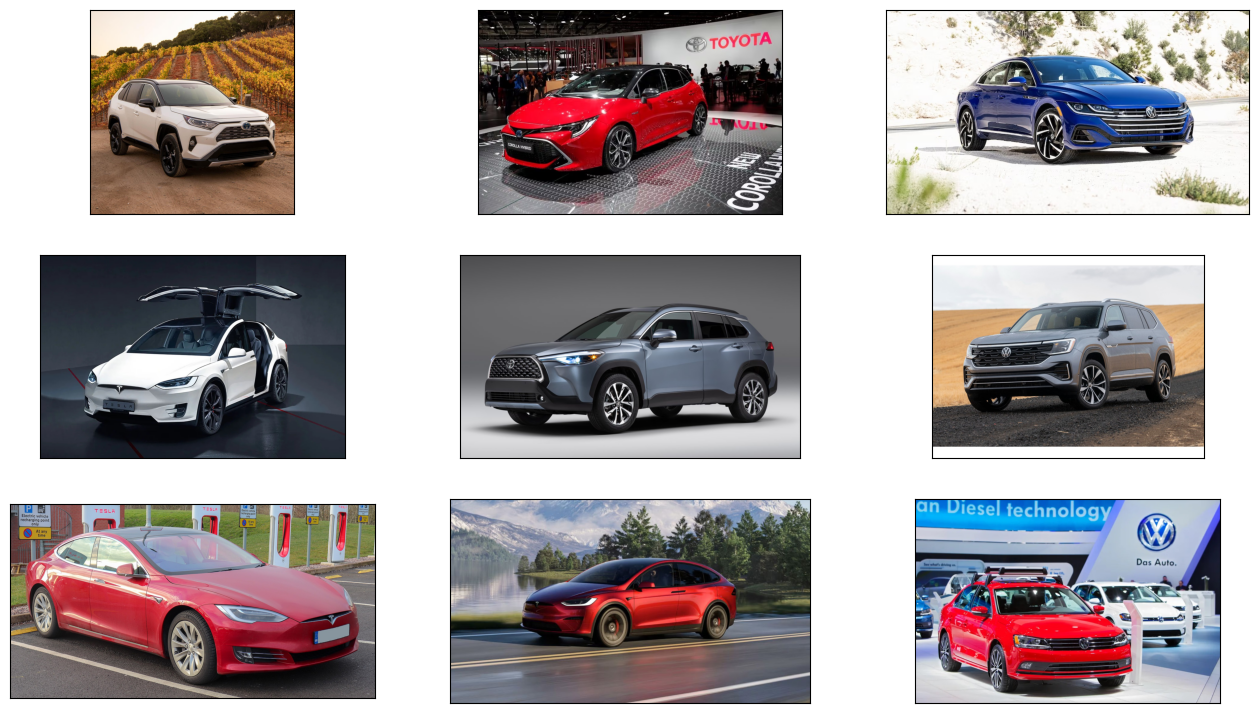

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./cars"):
    image_paths.append(str(os.path.join("./cars", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if ".jpg" in img_path:
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths)

### Using GPT4V to understand those input images

In [ ]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index import SimpleDirectoryReader

image_documents = SimpleDirectoryReader(input_files=["./cars/o1.jpg","./cars/t1.jpg","./cars/v1.jpg"]).load_data()

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", api_key=OPENAI_API_TOKEN, max_new_tokens=1500
)

response_1 = openai_mm_llm.complete(
    prompt="Describe the car in the image",
    image_documents=image_documents,
)

print(response_1)

The images depict three different cars; I'll describe each one:

1. The first image shows a red hatchback displayed at an auto show, featuring the "Toyota" brand logo in the background, indicating that it's a Toyota vehicle. The model appears to be a Corolla Hybrid, which is indicated by the text on the floor. The car has a modern and sporty design, with sharp lines and accents on the body, a black roof, and a set of alloy wheels that give it an attractive look. At the bottom right of the image, you can see the word "Corolla" as a part of the vehicle display.

2. The second image features a red Tesla Model S, evident by its distinctive shape and the Tesla logo on the front grille area. This premium all-electric sedan has a sleek and aerodynamic design with flush door handles and a panoramic glass roof. It's parked at a charging station with several Tesla charging connectors in the background.

3. The third image displays an SUV, which is a Volkswagen, recognizable by the VW emblem on t

In [ ]:
!rm -rf qdrant_mm_db

## Build Multi-modal index and vector store to index both text and images

In [ ]:
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.vector_stores import QdrantVectorStore
from llama_index import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index import (
    SimpleDirectoryReader,
)

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_mm_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(vector_store=text_store,image_store=image_store)

# Create the MultiModal index
documents = SimpleDirectoryReader("./cars").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents, storage_context=storage_context
)

## Query text and images from our Multi-Modal Index

### Find the Toyotas

In [ ]:
# generate Text retrieval results
retriever_engine = index.as_retriever(
    similarity_top_k=3, image_similarity_top_k=3
)
retrieval_results = retriever_engine.retrieve("Find the Toyotas")

**Node ID:** 2ad2c878-b11f-404a-9cf8-9cd3244147fd<br>**Similarity:** 0.827718846217174<br>**Text:** Toyota is a Japanese multinational automotive manufacturer headquartered in Toyota City, Aichi, Japan.<br>

**Node ID:** b3382c2d-c277-4ab0-b903-0c92cf516423<br>**Similarity:** 0.8062235466460185<br>**Text:** After World War II, Toyota benefited from Japan's alliance with the United States to learn from American automakers and other companies, which gave rise to The Toyota Way (a management philosophy) ...<br>

**Node ID:** 678c25b9-a790-45d7-ad77-6d2f73fd32de<br>**Similarity:** 0.8010623381550429<br>**Text:** Toyota was praised for being a leader in the development and sales of more fuel-efficient hybrid electric vehicles, starting with the introduction of the Toyota Prius in 1997. The company now sells...<br>

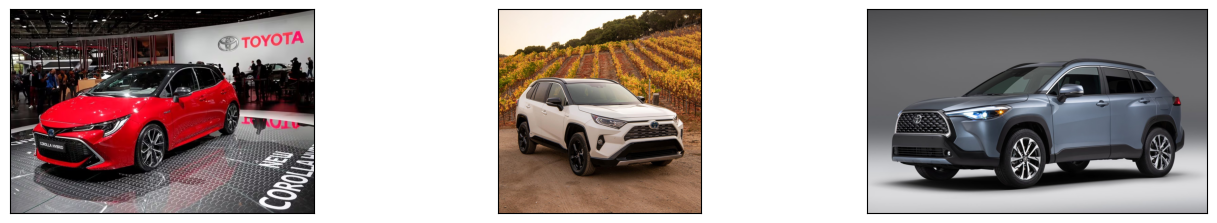

In [ ]:
from llama_index.response.notebook_utils import display_source_node
from llama_index.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

## Look for Teslas instead

In [ ]:
# generate Text retrieval results
retriever_engine = index.as_retriever(
    similarity_top_k=3, image_similarity_top_k=3
)
retrieval_results = retriever_engine.retrieve("Find the Teslas")

**Node ID:** 3f2f6714-c0f5-4fbf-a1c6-18e45a2dee88<br>**Similarity:** 0.8217452974002337<br>**Text:** Tesla, Inc is an American multinational automotive and clean energy company headquartered in Austin, Texas, which designs and manufactures electric vehicles<br>

**Node ID:** f951e7c0-06a3-4601-87dc-53105fde639e<br>**Similarity:** 0.8192227271301252<br>**Text:** Tesla was incorporated in July 2003 by Martin Eberhard and Marc Tarpenning as Tesla Motors. The company's name is a tribute to inventor and electrical engineer Nikola Tesla. In February 2004, via a...<br>

**Node ID:** 99ea8644-6a33-4643-a4e8-1ef1b557dbf7<br>**Similarity:** 0.8025846036658142<br>**Text:** Tesla has been the subject of lawsuits, government scrutiny, and journalistic criticism, stemming from allegations of whistleblower retaliation, worker rights violations, product defects, and Musk'...<br>

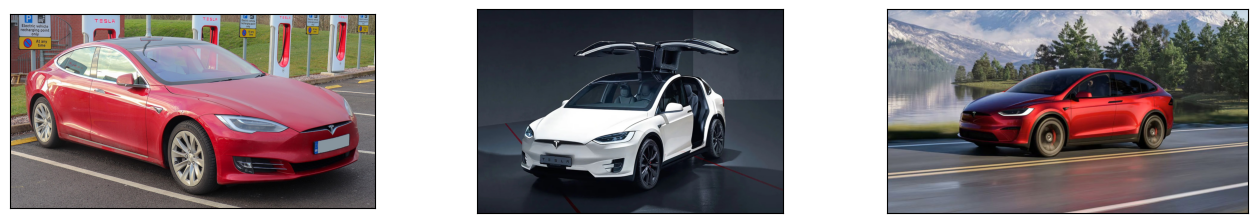

In [ ]:
from llama_index.response.notebook_utils import display_source_node
from llama_index.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

In [ ]:
query_engine = index.as_query_engine(
    similarity_top_k=3, image_similarity_top_k=3
)
response = query_engine.query("Compare the toyotas")
print(response)

In the images provided, you can see three different Toyota vehicles:

1. The first vehicle is a red Toyota Corolla Hybrid, which is showcased at a car show. You can notice the distinctive Toyota logo and styling, indicating it is a hybrid model due to the badging.

2. The second image shows a blue Toyota SUV, which is larger and has a different design compared to the compact hatchback of the Corolla Hybrid. This model appears to have the features of a modern crossover or SUV.

3. The third vehicle is a white Toyota SUV with black trim elements, giving it a more rugged or sporty appearance. It is similar to the second vehicle in terms of being a larger SUV but differs in color and specific design elements.

Each of these vehicles reflects Toyota's design language and the diversity of their vehicle lineup, which ranges from compact hybrid cars to larger, more traditional SUV models. The images demonstrate the variety in size, functionality, and possibly the technology used in the differe